In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os import listdir
from os.path import isdir, join

import pickle as pk
import glob

In [2]:
custom_params = {
    "axes.grid": True,
    "axes.spines.right": False,
    "axes.spines.top": False,
}

## 1. Hopper

### Ours

In [3]:
env = "Hopper-v3"
cdir = f"logs/{env}/"

def smooth(arr, mask_size):
    s = pd.Series(arr)
    return s.rolling(mask_size).mean()

In [4]:
tqc_rewards = []
sac_rewards = []

for d in listdir(cdir):
    path = join(cdir, d)
    if not isdir(path):
        continue

    if "TQC" in d:
        with np.load(path + "/evaluations.npz") as data:
            tqc_rewards.append(data["results"])
            timesteps = data["timesteps"]

    elif "SAC" in d:
        with np.load(path + "/evaluations.npz") as data:
            sac_rewards.append(data["results"])
        
mask_size = 100

tqc_mean = smooth(np.mean(tqc_rewards, axis=(0,2)), mask_size=mask_size)
tqc_std = tqc_mean.std()

sac_mean = smooth(np.mean(sac_rewards, axis=(0,2)), mask_size=mask_size)
sac_std = tqc_mean.std()

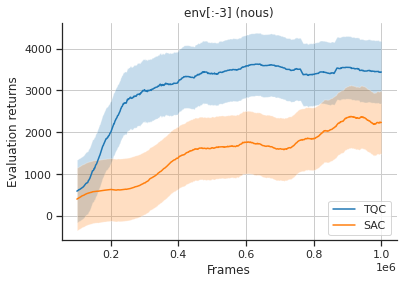

In [5]:
sns.set_theme(style="ticks", palette="tab10", rc=custom_params)

fig, ax = plt.subplots()

ax.plot(timesteps, tqc_mean, label="TQC")
ax.fill_between(timesteps, tqc_mean + tqc_std, tqc_mean - tqc_std, alpha=0.25)

ax.plot(timesteps, sac_mean, label="SAC")
ax.fill_between(timesteps, sac_mean + sac_std, sac_mean - sac_std, alpha=0.25)

ax.set_title(f"env[:-3] (nous)")
ax.set_xlabel("Frames")
ax.set_ylabel("Evaluation returns")
ax.legend(loc='lower right')
# ax.set_xlim(xmax=3e6)
# ax.legend(loc='upper right') 

fig.show()
fig.savefig(
    f"plots/{env[:-3].lower()}_tqc_sac_smoothed.png", facecolor="white", transparent=False
)

### Paper

In [6]:
with open("data/tqc_curves.pkl", "rb") as f:
    tqc_curves = pk.load(f)
    
t = np.linspace(0, 3e6, 3001)

t_mean = np.mean(tqc_curves["Hopper"]["TQC"], axis=0)
t_smoothed = smooth(t_mean, mask_size=100)
t_std = t_smoothed.std()

s_mean = np.mean(tqc_curves["Hopper"]["SAC"], axis=0)
s_smoothed = smooth(s_mean, mask_size=100)
s_std = s_smoothed.std()

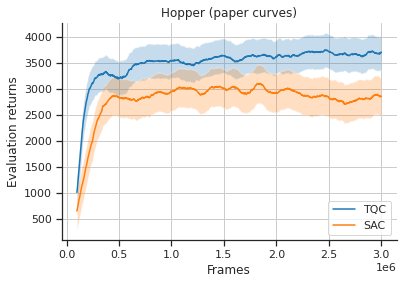

In [7]:
fig, ax = plt.subplots()

ax.plot(t, t_smoothed, label="TQC")
ax.fill_between(t, t_smoothed + t_std, t_smoothed - t_std, alpha=0.25)

ax.plot(t, s_smoothed, label="SAC")
ax.fill_between(t, s_smoothed + s_std, s_smoothed - s_std, alpha=0.25)

ax.set_title(f"{env[:-3]} (paper curves)")
ax.set_xlabel("Frames")
ax.set_ylabel("Evaluation returns")
ax.legend(loc='lower right')

plt.show()
fig.savefig(
    f"plots/{env[:-3].lower()}_tqc_sac_original.png", facecolor="white", transparent=False
)

## 2. Single State MDP

### Reward function

In [8]:
from single_state_mdp import SingleStateMDP

In [9]:
n = 50

env = SingleStateMDP()
actions = np.linspace(-1, 1, n)
rewards = np.zeros(n)
targets = np.zeros(n)

In [10]:
env.reset()

for i, action in enumerate(actions):
    a = action.item()
    _, reward, _, _ = env.step(a)
    targets[i] = env._mean_reward(a)
    rewards[i] = reward


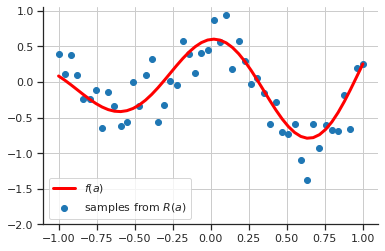

In [11]:
sns.set_theme(style="ticks", palette="tab10", rc=custom_params)

plt.plot(actions, targets, color="r", linewidth=3, label='$f(a)$')
plt.scatter(actions, rewards, label='samples from $R(a)$')

plt.ylim(ymin=-2)
plt.legend()
# plt.savefig("plots/reward_function")
plt.show()